In [2]:
import pandas as pd
import re
import pmdarima as pm
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pulp

/Users/oliver.cairns/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Users/oliver.cairns/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


### Load data

In [3]:
def camelcase_columns(df):
    df.columns = [re.sub( r'(\n)?(\s)+', ' ', c).strip().lower().replace(' ','_').replace('£','p') for c in df.columns]
    return df

In [4]:
def prepare_data(path_2017, path_2018):
    # load datasets
    season_18_df = pd.read_csv(path_2017)
    season_17_df = pd.read_excel(path_2018)
    # make column names consistent, and camelcase
    season_18_df = camelcase_columns(season_18_df)
    season_17_df = camelcase_columns(season_17_df)
    # add season numbers
    season_17_df['season'] = 2017
    season_18_df['season'] = 2018
    # append
    combined_df= season_17_df.append(season_18_df,sort=False)
    # add player id, and coerce value from string to numeric
    combined_df['player_id'] = combined_df.name + '-' + combined_df.position
    combined_df['p_value'] = pd.to_numeric(combined_df.p_value.str.replace('£',''))
    
    return combined_df

In [5]:
combined_df = prepare_data(path_2017='../data/2018_19_current_season_data.csv',
                          path_2018='../data/FPL-201718-player-stats.xlsx')

In [6]:
both_season_players = (set(combined_df.loc[combined_df.season==2018,'player_id'])
                        .intersection(set(combined_df.loc[combined_df.season==2017,'player_id'])))

### Fit basic timeseries model for each player 
fit using 2017 data - for now no covariates

storing prediction - mean forecast for first 10 games of next season

In [60]:
def fit_autoarima(data, player_id, n_periods=10):
    train = data.loc[(data.player_id == player_id) &
                     (data.season == 2017),'pts']

    # Fit a simple auto_arima model
    model = pm.auto_arima(train,seasonal=False,
                         stepwise=True, suppress_warnings=True, D=10, max_D=10,
                         error_action='ignore')
    
    
    # Create predictions for the future
    preds, _ = model.predict(n_periods=n_periods, return_conf_int=True)
    
    return model, preds.mean()

In [59]:
def plot_autoarma(data,player_id, model,n_periods=10):
    train = data.loc[(data.player_id == player_id) &
                     (data.season == 2017),'pts']
    
    test = data.loc[(data.player_id == player_id) &
             (data.season == 2018) &
             (data.gw_gameweek < 11),'pts']
    
    # Create predictions for the future
    preds, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)

    print(f"Test RMSE: {player_id} %.3f" % np.sqrt(mean_squared_error(test, preds)))

    train_idx = np.arange(1,train.shape[0]+1)
    test_idx = np.arange(train.shape[0]+1,test.shape[0]+train.shape[0]+1)

    plt.plot(train_idx, train, alpha=0.75)
    plt.plot(test_idx, preds, alpha=0.75)  # Forecasts
    plt.scatter(test_idx, test,
                alpha=0.4, marker='x')  # Test data
    plt.fill_between(test_idx,
                     conf_int[:, 0], conf_int[:, 1],
                     alpha=0.1, color='b')
    plt.title(f"Points forecast - {player_id}")
    plt.xlabel("Gameweek")
    plt.show()


In [61]:
def fit_all_models(both_season_players):
    models = {'player_id':[],
             'prediction_ts':[]}
    for i,p in enumerate(both_season_players):
        try:
            _, prediction = fit_autoarima(combined_df, p)
            models['prediction_ts'].append(prediction)
            models['player_id'].append(p) 
        except:
            print(f'player {p} failed')
    predictions = pd.DataFrame(models)
    return predictions

In [62]:
predictions = fit_all_models(both_season_players)

/Users/oliver.cairns/anaconda3/lib/python3.7/site-packages/pmdarima/arima/auto.py:253: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/Users/oliver.cairns/anaconda3/lib/python3.7/site-packages/pmdarima/arima/auto.py:253: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/Users/oliver.cairns/anaconda3/lib/python3.7/site-packages/pmdarima/arima/auto.py:253: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/Users/oliver.cairns/anaconda3/lib/python3.7/site-packages/pmdarima/arima/auto.py:253: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/Users/oliver.cairns/anaconda3/lib/python3.7/site-packages/pmdarima/arima/au

top predictions
           player_id  prediction_ts
192  van Aanholt-DEF      17.301803
267        Salah-MID       7.973684
312  Milivojevic-MID       6.829412
4          Pérez-FWD       6.530504
226    Robertson-DEF       6.081683


### Merge predictions with prices

also add previous season points

In [55]:
def prepare_candidate_df(data, predictions):
    prev_points = combined_df.loc[combined_df.season==2017].groupby('player_id')[['pts']].sum().reset_index().rename(columns={'pts':'prediction_prev'})
    prev_points.prediction_prev /= 38
    
    candidates = (data.loc[(data.gw_gameweek==1)&
                   (data.season == 2018),
                     ['player_id','p_value','team', 'position']]
            .drop_duplicates(['player_id'])
    .merge(predictions,on='player_id',how='inner')
    .merge(prev_points,on='player_id',how='inner')
            .sort_values(by='prediction_ts',ascending=False))
    return candidates.loc[candidates.prediction_ts.notna()].reset_index(drop=True)

In [56]:
candidates = prepare_candidate_df(combined_df,predictions)

### Show characteristics of top *n* candidates

quite jokes that van Aanholt is so high - some sensible names here though

In [57]:
def show_top_candidates(candidates, n = 20):
    print('time series candidates')
    print(candidates.sort_values(by='prediction_ts',ascending=False).drop(columns=['prediction_prev']).head(n))
    sns.scatterplot(data=candidates,x='p_value',y='prediction_ts',hue='position')
    plt.show()
    
    for p in candidates.head(n).player_id:
        model, _ = fit_autoarima(combined_df, p)
        plot_autoarma(combined_df,p, model)
    
    print('season total candidates')
    print(candidates.sort_values(by='prediction_prev',ascending=False).drop(columns=['prediction_ts']).head(n))

    sns.scatterplot(data=candidates,x='p_value',y='prediction_prev',hue='position')
    plt.show()


time series candidates
               player_id  p_value team position  prediction_ts
0        van Aanholt-DEF      5.5  CRY      DEF      17.301803
1              Salah-MID     13.0  LIV      MID       7.973684
2        Milivojevic-MID      6.5  CRY      MID       6.829412
3              Pérez-FWD      6.5  NEW      FWD       6.530504
4          Robertson-DEF      6.0  LIV      DEF       6.081683
5           Sterling-MID     11.0  MCI      MID       6.026316
6            Tomkins-DEF      4.5  CRY      DEF       6.012381
7               Kane-FWD     12.5  TOT      FWD       5.754370
8          De Bruyne-MID     10.0  MCI      MID       5.500000
9            Eriksen-MID      9.5  TOT      MID       5.236842
10            Mahrez-MID      9.0  MCI      MID       5.131579
11  Alexander-Arnold-DEF      5.0  LIV      DEF       4.919305
12           Lejeune-DEF      4.5  NEW      DEF       4.883526
13             Vardy-FWD      9.0  LEI      FWD       4.815789
14            Rondón-FWD      6.

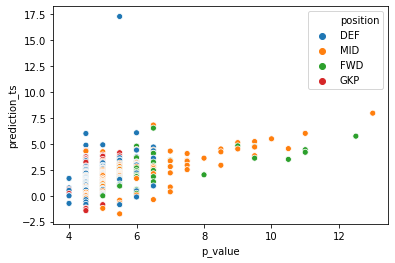

Test RMSE: van Aanholt-DEF 14.279


NameError: name 'train' is not defined

In [58]:
show_top_candidates(candidates)

### Select best 15 players

choose highest expected points per game, subject to constraints on total cost, and positions 

note - doesn't capture fact that subs are less valuable (particularly 2nd keeper)

In [35]:
def select_best_15(data,prediction_col):
    player_ids = [str(i) for i in range(data.shape[0])]

    # Setup
    point = dict(zip(player_ids,data[prediction_col]))
    cost = dict(zip(player_ids,data.p_value))
    gk = dict(zip(player_ids,(data.position == 'GKP').astype(int)))
    defe = dict(zip(player_ids,(data.position == 'DEF').astype(int)))
    mid = dict(zip(player_ids,(data.position == 'MID').astype(int)))
    stri = dict(zip(player_ids,(data.position == 'FWD').astype(int)))
    
    prob = pulp.LpProblem("Fantasy Football",pulp.LpMaximize)
    player_vars = pulp.LpVariable.dicts("Players",player_ids,0,1,pulp.LpBinary)

    # objective function
    prob += pulp.lpSum([point[i]*player_vars[i] for i in player_ids]), "Total Cost"

    # constraint
    prob += pulp.lpSum([player_vars[i] for i in player_ids]) == 15, "Total 15 Players"
    prob += pulp.lpSum([cost[i] * player_vars[i] for i in player_ids]) <= 100.0, "Total Cost"
    prob += pulp.lpSum([gk[i] * player_vars[i] for i in player_ids]) == 2, "2 GK"
    prob += pulp.lpSum([defe[i] * player_vars[i] for i in player_ids]) == 5, "5 DEF"
    prob += pulp.lpSum([mid[i] * player_vars[i] for i in player_ids]) == 5, "5 MID"
    prob += pulp.lpSum([stri[i] * player_vars[i] for i in player_ids]) == 3, "Less than 3 STR"

    # solve
    status = prob.solve()
    
    return status, prob, [int(f.name.replace('Players_','')) for f in prob.variables() if f.varValue == 1 ]

In [38]:
_, _, selections_ts = select_best_15(candidates,'prediction_ts')

In [40]:
_, _, selections_prev_total = select_best_15(candidates,'prediction_prev')

In [43]:
def show_team(candidates, selection):
    position_map = {'GKP':1,'DEF':2,'MID':3,'FWD':4}
    candidates['position_num'] = candidates.position.map(position_map)
    return candidates.iloc[selections_ts].sort_values(by='position_num').drop(columns='position_num')

In [42]:
position_map = {'GKP':1,'DEF':2,'MID':3,'FWD':4}

In [45]:
selected_players_ts = show_team(candidates,selections_ts); selected_players_ts

,player_id,p_value,team,position,prediction_ts,prediction_prev
25,McCarthy-GKP,4.5,SOU,GKP,4.380676,1.368421
36,Pope-GKP,5.0,BUR,GKP,3.943316,4.000000
0,van Aanholt-DEF,5.5,CRY,DEF,17.301803,2.500000
11,Alexander-Arnold-DEF,5.0,LIV,DEF,4.919305,2.184211
12,Lejeune-DEF,4.5,NEW,DEF,4.883526,1.736842
4,Robertson-DEF,6.0,LIV,DEF,6.081683,2.921053
6,Tomkins-DEF,4.5,CRY,DEF,6.012381,2.605263
1,Salah-MID,13.0,LIV,MID,7.973684,7.973684
2,Milivojevic-MID,6.5,CRY,MID,6.829412,3.789474
28,Westwood-MID,4.5,BUR,MID,4.308236,0.921053


In [46]:
selected_players_prev_total = show_team(candidates,selections_prev_total); selected_players_prev_total

,player_id,p_value,team,position,prediction_ts,prediction_prev
25,McCarthy-GKP,4.5,SOU,GKP,4.380676,1.368421
36,Pope-GKP,5.0,BUR,GKP,3.943316,4.000000
0,van Aanholt-DEF,5.5,CRY,DEF,17.301803,2.500000
11,Alexander-Arnold-DEF,5.0,LIV,DEF,4.919305,2.184211
12,Lejeune-DEF,4.5,NEW,DEF,4.883526,1.736842
4,Robertson-DEF,6.0,LIV,DEF,6.081683,2.921053
6,Tomkins-DEF,4.5,CRY,DEF,6.012381,2.605263
1,Salah-MID,13.0,LIV,MID,7.973684,7.973684
2,Milivojevic-MID,6.5,CRY,MID,6.829412,3.789474
28,Westwood-MID,4.5,BUR,MID,4.308236,0.921053
